# Bifurcation diagrams in Python


(glanced at [this code](https://github.com/henrifroese/infectious_disease_modelling/blob/master/part_two.ipynb) to remind myself of stuff ...)

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
def grad(t, y, parms):
    """seasonally forced SIR.
    beta0: contact rate (/year)
    beta1: seasonal amplitude
    N: pop size
    gamma: recovery rate (/year)
    mu: birth/death rate (/year)"""
    beta0, beta1, N, gamma, mu = parms
    S, I, R = y
    incidence = beta0*(1+beta1*np.cos(2*np.pi*t)/2)*S*I/N
    return (-incidence+mu*(N-S), incidence-(mu+gamma)*I, gamma*I-mu*R)
    ## beta0 beta1  N   gamma   mu
p0 = (15*52, 0.1,  1.0, 52,     1.0/50.0 ) ## R0=15; inf per=1 week; life=50 yr
p1 = (15*52, 0.0,  1.0, 52,     0        )  ## no forcing, no vital dynamics: plain SIR
y0 = (0.6, 0.01, 0.39)
grad(0, y0, p0)

(-4.906, 4.3938, 0.5122)

In [2]:
def lgrad(t, y, parms):
    """seasonally forced SIR, I computed on log scale
    beta0: contact rate (/year)
    beta1: seasonal amplitude
    N: pop size
    gamma: recovery rate (/year)
    mu: birth/death rate (/year)"""
    ## d(log I)/dt = (dI/dt)/I
    beta0, beta1, N, gamma, mu = parms
    S, logI, R = y
    ## divide by 2 [beta1=(beta(max)-beta(min))/beta0]
    inc2 = beta0*(1+beta1*np.cos(2*np.pi*t)/2)*S/N
    return (-inc2 *np.exp(logI)+mu*(N-S), 
             inc2 - (mu+gamma), 
             gamma*np.exp(logI)-mu*R)

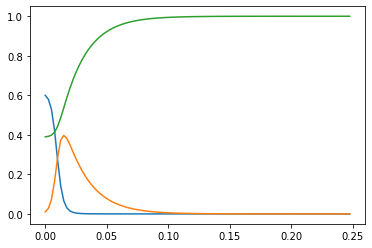

In [3]:
## regular SIR (no forcing, no birth)
t = np.arange(0, 0.25, 1/400)
ret = solve_ivp(grad, t_eval=t, t_span=[0,10], y0=y0, args=(p1,) )
plt.plot(ret.t, ret.y.T);

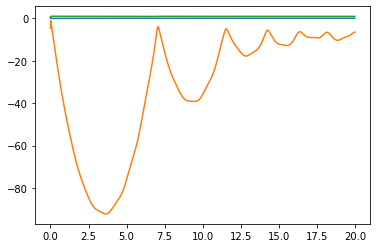

In [4]:
t = np.arange(0, 20, 1/52)
yl0 = (0.6, np.log(0.01), 0.39)
ret = solve_ivp(lgrad, t_eval=t, t_span=[0,20], 
                y0=yl0, args=(p0,), rtol=1e-8, method="LSODA" )
plt.plot(ret.t,ret.y.T);

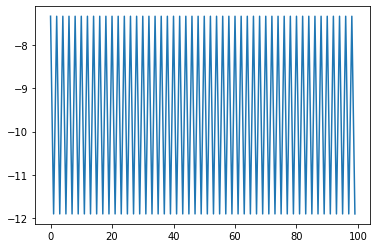

In [5]:
def run_bif_iteration(b1,transient=400,maxt=500,dt=1, y0=yl0):
    tvec = np.arange(transient, maxt, dt)
    pbif = list(p0)
    pbif[1] = b1
    pbif = tuple(pbif)
    ## print(pbif)
    bifret = solve_ivp(lgrad, t_eval=tvec, t_span=[0,maxt], 
                       y0=y0, args=(pbif,),
                       ## fussing with tolerances etc.; loosen
                       ## these as much as possible while avoiding
                       ## errors
                       rtol=1e-10,atol=1e-10, method="LSODA",
                      ## max_step=1/730
                      )
    ## return both the vector of (log) I *and* the final state
    ##   (as a tuple)
    return((bifret.y[1,:],bifret.y[:,-1]))

r = run_bif_iteration(0.12,transient=100,maxt=200)
plt.plot(r[0]);

In [6]:
nbif=100  ## number of bifurcation value parameters to try
maxb1 = 0.25
maxbift = 200
biftransient = 100
biftvec = np.arange(biftransient,maxbift,1)
b1vec = np.linspace(0,maxb1,nbif)
bifout = np.zeros(shape=(len(biftvec),nbif))
by0 = yl0  ## initial value for bifurc runs
for i in range(nbif):
    if (i % 10 ==0):  ## fancy progress bar
        print("*",end="")
    else:
        print(".",end="")  ## progress
    try:
        r = run_bif_iteration(b1vec[i],transient=biftransient,
                                       maxt=maxbift, y0=by0)
        ## continuation method (use end state of previous run
        ##  as starting value for the next)
        bifout[:,i] = r[0]
        by0 = r[1]
    except:
        print("bad")

*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........

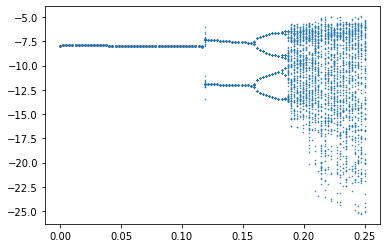

In [7]:
## 100 x 50 array of log(I) values
## length-50 array of b1 values
plt.plot(np.tile(b1vec,len(biftvec)),
         bifout.flatten(),"o",markersize=0.5);

This looks pretty good. The abrupt transition from annual to biennial cycles near $\beta_1=0.11$ is probably not really a discontinuous bifurcation (there are probably multiple coexisting attractors here, and we 'jumped' from one to the other even though the continuation method tries to keep us in a single basin). We could expand this to try many initial conditions (or look at the 2D bifurcation diagram for $\{\beta_0 \times \beta_1\}$ ...)

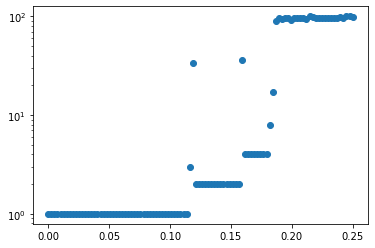

In [8]:
## approximate period; uniqueness at the level of two decimal
## places
bif_period = np.zeros(nbif)
for i in range(nbif):
    bif_period[i] = len(np.unique(np.round(bifout[:,i],2)))
plt.semilogy(b1vec,bif_period,"o");